In [38]:
"Importing necessary packages."

import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

In [39]:
"Creating a function with known first and second order derivatives and random paramters to generate training data."

class TrainingFunc():
  def __init__(self):
    self.vals = np.random.uniform(-5, 5, 3)
    self.step = np.random.uniform(0.0001, 0.1)
    
  def pos(self, x): return self.vals[0] * x**3 + self.vals[1] * x**2 + self.vals[2] * x
  def vel(self, x): return 3 * self.vals[0] * x**2 + 2 * self.vals[1] * x + self.vals[2]
  def acc(self, x): return 6 * self.vals[0] * x + 2 * self.vals[1]

In [40]:
"Generating the training data"

ini_training_func = TrainingFunc()

input_data = np.array([ini_training_func.step, ini_training_func.pos(0), 
                         ini_training_func.vel(0), ini_training_func.acc(0)])

target_data = np.array([ini_training_func.pos(ini_training_func.step), 
                          ini_training_func.vel(ini_training_func.step)])

for i in range(9999):
  new_training_func = TrainingFunc()
  randx = np.random.uniform(-5, 25)

  new_input_data = np.array([new_training_func.step, new_training_func.pos(randx), 
                         new_training_func.vel(randx), new_training_func.acc(randx)])
  
  new_target_data = np.array([new_training_func.pos(randx + new_training_func.step), 
                          new_training_func.vel(randx + new_training_func.step)])
  
  input_data = np.vstack((input_data, new_input_data))
  target_data = np.vstack((target_data, new_target_data))

In [49]:
"Defining the model."

np.random.seed(173)

num_inputs = 4
num_hidden = 3
num_outputs = 2

graph = tf.Graph()

with graph.as_default():
  inputs = tf.placeholder(tf.float32, shape=[None, num_inputs])
  targets = tf.placeholder(tf.float32, shape=[None, num_outputs])

  hidden_weights = tf.Variable(tf.truncated_normal([num_inputs + 1, num_hidden]))
  hidden_biases = tf.Variable(tf.zeros([1, num_hidden]))

  output_weights = tf.Variable(tf.truncated_normal([num_hidden + 1, num_outputs]))
  output_biases = tf.Variable(tf.zeros([1, num_outputs]))

  hidden_layer = tf.nn.dropout(tf.nn.relu(tf.matmul(tf.concat([inputs, tf.ones([tf.shape(inputs)[0], 1])], axis=1), hidden_weights) + hidden_biases), rate=0.5)
  output_layer = tf.matmul(tf.concat([hidden_layer, tf.ones([tf.shape(inputs)[0], 1])], axis=1), output_weights) + output_biases

  loss = tf.reduce_mean(tf.square(targets - output_layer))
  optimizer = tf.train.AdamOptimizer().minimize(loss)

  init = tf.global_variables_initializer()

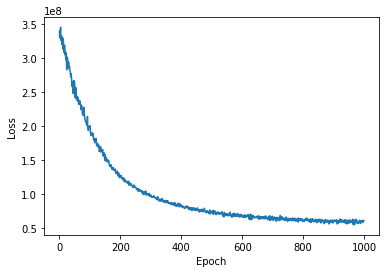

In [46]:
"Training the model."

with tf.Session(graph=graph) as sess:
    sess.run(init)

    #noisy_input_data = input_data + np.random.normal(scale=0.1, size=input_data.shape)

    losses = []
    for i in range(1000):
        _, loss_val = sess.run([optimizer, loss], feed_dict={inputs: input_data, targets: target_data})
        losses.append(loss_val)
        
    saver = tf.train.Saver()
    save_path = saver.save(sess, "my_model.ckpt")

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [63]:
"Testing the model on a simple harmonic oscillator."

class Oscillator:
  def __init__(self, a, h):
    self.a = a
    self.sqrta = np.sqrt(a)
    self.ini = np.array([h, 0, self.sqrta, 0])

  def acc(self, pos):
    return self.a * np.sin(pos)

  def vel(self, t):
    return self.sqrta * np.cos(self.sqrta * t)

  def pos(self, t):
    return np.sin(self.sqrta * t)

h = 0.01
a = 1
oscillator = Oscillator(a, h)
exact_sol = [oscillator.ini[1]]
model_sol = [oscillator.ini[1]]

with tf.Session(graph=graph) as sess:
  saver = tf.train.Saver()
  saver.restore(sess, "my_model.ckpt")

  prediction = sess.run(output_layer, feed_dict={inputs: oscillator.ini.reshape((1, 4))})
  print(prediction)
  model_sol.append(prediction[0,0])
  exact_sol.append(oscillator.pos(h))

  for i in range(2, 100):
   exact_sol.append(oscillator.pos(i * h))
   input_data = np.array([h, prediction[0,0], prediction[0,1], oscillator.acc(prediction[0,0])]).reshape((1, 4))
   prediction = sess.run(output_layer, feed_dict={inputs: input_data})
   model_sol.append(prediction[0,0])

[[-0.7575526 -0.9520094]]


In [64]:
print(model_sol)

[0.0, -0.7575526, -0.90547323, -0.7575526, -0.90547323, -1.3611871, -0.7575526, 0.21760327, -0.7575526, 0.21760327, -0.7575526, -0.90547323, -0.7575526, -1.8806293, -0.36270338, -0.9984907, -1.2974675, -0.7575526, 0.21760327, -0.7575526, 0.21760327, -0.7575526, 0.21760327, -0.7575526, 0.21760327, -0.7575526, -0.90547323, -1.3611871, -0.7575526, 0.21760327, -0.7575526, -0.90547323, -1.3611871, -2.6401436, -0.7575526, -1.8806293, -3.1144564, -3.6800344, -0.7575526, -1.8806293, -0.7575526, -0.90547323, -0.7575526, -0.7575526, 0.21760327, -0.7575526, -0.7575526, -1.8806293, -0.36270338, -0.7575526, -1.8806293, -0.36270338, -0.9984907, -2.2080495, -0.6720525, -0.7575526, 0.21760327, -0.7575526, -0.90547323, -1.3611871, -2.6401436, -3.5261588, -3.808016, -0.7575526, -1.8806293, -2.719607, -3.261976, -3.7238934, -0.7575526, -0.90547323, -1.3611871, -2.6401436, -3.5261588, -3.808016, -3.9166648, -3.9663956, -3.9909098, -4.0034246, -4.009927, -0.7575526, -1.8806293, -2.719607, -3.261976, -0.757

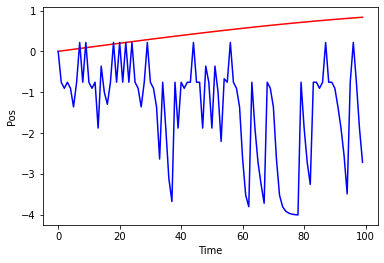

In [65]:
plt.plot(exact_sol, 'r')
plt.plot(model_sol, 'b')
plt.xlabel("Time")
plt.ylabel("Pos")
plt.show()